# Monte Carlo in spinfoams

Description of the notebook

## Setup

In [2]:
using CSV
using DataFrames
using HalfIntegers, JLD2, Distributions, Random
using LaTeXStrings

In [3]:
using Statistics
using StatsBase
using StatsPlots

In [4]:
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
)
scalefontsizes(1.3)

# Decide how many monte carlo samples we take

We compare the results of MC sampling with $N_{mc}=1\,000$, $N_{mc}=10\,000$, $N_{mc}=100\,000$ samples. We compare with the exact result for the amplitude. 
We estimate the value of the Layers averaging over 20 trials and the error with the standard deviation. Then we sum the average value of the layers and we sum variances

In [1]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 1 method)

In [10]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

In [11]:
error_relative_Nmc1K = error_Nmc1K./amplitude_Nmc1K;

In [12]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc10K = error_Nmc10K./amplitude_Nmc10K;

In [13]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

error_relative_Nmc100K = error_Nmc100K./amplitude_Nmc100K;

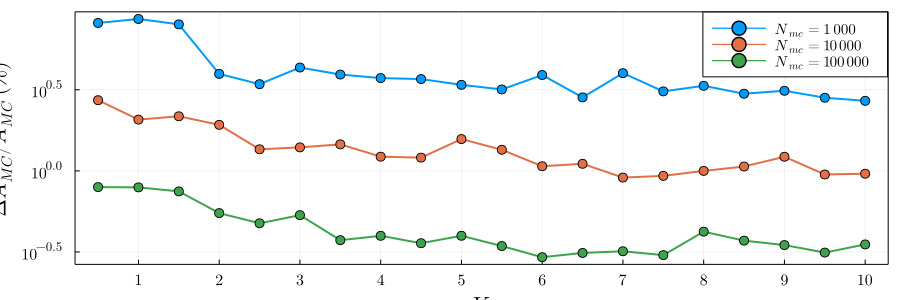

In [44]:
plot1 = plot(0.5:0.5:10,
               [100 .*error_relative_Nmc1K,100 .*error_relative_Nmc10K,100 .*error_relative_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               #label = ["1K" "10K" "100K"],
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.861,0.935),
               size = (900, 300),
               ylabel = L"\Delta A_{MC}/A_{MC} \ (\%)",
               xlabel = "K",
            #    yerror= [error_relative_Nmc1K,error_relative_Nmc10K],
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

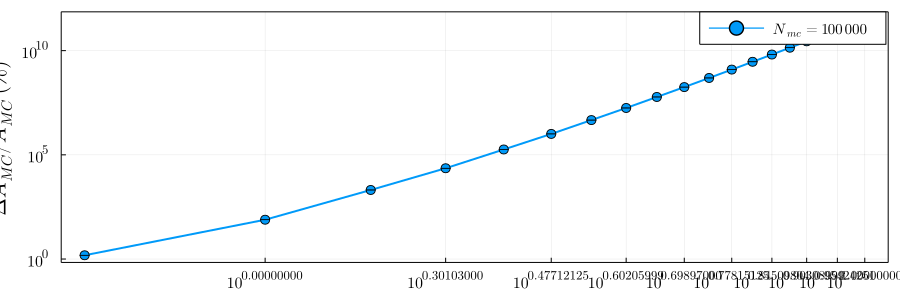

In [48]:
plot1 = plot(0.5:0.5:10,
               amplitude_Nmc100K,
               label = L"$N_{mc}=100\,000$",
               #label = ["1K" "10K" "100K"],
               #title = ["Comparison with exact"],
               yscale=:log10,
               xscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.861,0.935),
               size = (900, 300),
               ylabel = L"\Delta A_{MC}/A_{MC} \ (\%)",
               xlabel = "K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

# Fitting the amplitude to find the scaling

We fit the amplitude as a function of the cutoff K using least squares fit. We use as a model the function 
$$ c_2K^{c_1} +  c_3 K^{c_1-1} +  c_4$$
and we perform the fit using only the last 10-ish points.

In [49]:
using LsqFit

In [51]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K[10:end], c0)
fit.param

4-element Vector{Float64}:
  10.71999070711705
   8.727707784882448
 -24.15904761444585
   3.0121534825902396e8

In [52]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
  0.60154995447956
 15.540721714442453
 68.0910204700939
  3.912511035770934e8

We cannot discriminate between $c_1=8$, $8.5$ or $9$. To circumvent this problem we look at the amplitudes with modified face amplitude 
$$ A_f(j_f) = (2j_f+1) \to (2j_f+1)^\mu$$
using as possible values of $\mu=1/6$, $\mu=0$, and $\mu=-1/6$.

In [53]:
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


get_data_mu0 (generic function with 1 method)

In [54]:
function get_data_mu02(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.2/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data_mu02 (generic function with 1 method)

In [61]:
function get_data_mu05(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.5/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data_mu05 (generic function with 1 method)

In [62]:
layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);

In [63]:
layers_trials_mu02 = DataFrame()
for trial in 1:20
    layers_trials_mu02[!,"$(trial)"]=[get_data_mu02(100000, trial).amp[id] - get_data_mu02(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu02 =  [mean(row) for row in eachrow(layers_trials_mu02)];
layers_variance_mu02 =  [var(row) for row in eachrow(layers_trials_mu02)];
amplitude_Nmc100K_mu02 = [sum(layers_average_mu02[1:id]) for id in 1:20];
error_Nmc100K_mu02 = sqrt.([sum(layers_variance_mu02[1:id]) for id in 1:20]);

In [64]:
layers_trials_mu01 = DataFrame()
for trial in 1:20
    layers_trials_mu01[!,"$(trial)"]=[get_data_mu01(100000, trial).amp[id] - get_data_mu01(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu01 =  [mean(row) for row in eachrow(layers_trials_mu01)];
layers_variance_mu01 =  [var(row) for row in eachrow(layers_trials_mu01)];
amplitude_Nmc100K_mu01 = [sum(layers_average_mu01[1:id]) for id in 1:20];
error_Nmc100K_mu01 = sqrt.([sum(layers_variance_mu01[1:id]) for id in 1:20]);

The Monte Carlo approximation of the amplitude works well also in the case of modified $\mu$

We fit the amplitude with $\mu=0$

In [65]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

4-element Vector{Float64}:
  1.917691023767898
  0.20072389789294617
 -0.17046812271235323
  0.19675945891197397

In [66]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.1376666192795975
 0.0958939075266767
 0.4717879237792495
 0.781720710297326

It is reasonable that the exponent is not exactly compatible with $4$ since we are just using an approximation for the scaling. 

In [67]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu02[10:end], c0)
fit.param

4-element Vector{Float64}:
 3.9540452206679566
 0.1003698241493843
 0.2345853000120932
 0.7848687046462351

In [68]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.1309782875660328
 0.04639128441709442
 0.09314620153460469
 2.182034472125777

In [ ]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu01[10:end], c0)
fit.param

4-element Vector{Float64}:
 3.9540452206679566
 0.1003698241493843
 0.2345853000120932
 0.7848687046462351

In [ ]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.1309782875660328
 0.04639128441709442
 0.09314620153460469
 2.182034472125777

# Repeat the analysis for the other boundary intertwiner

In [52]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/exact/BF/weight_1.0/ib_1/ampls_cutoff_10.csv",
        ),
    )
end

get_self_energy_exact (generic function with 1 method)

In [53]:
exact_amplitude = get_self_energy_exact().amp[2:end];
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);
relative_Nmc1K = amplitude_Nmc1K./exact_amplitude .-1;
error_relative_Nmc1K = error_Nmc1K./exact_amplitude;
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc10K = amplitude_Nmc10K./exact_amplitude .-1;
error_relative_Nmc10K = error_Nmc10K./exact_amplitude;
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc100K = amplitude_Nmc100K./exact_amplitude .-1;
error_relative_Nmc100K = error_Nmc100K./exact_amplitude;

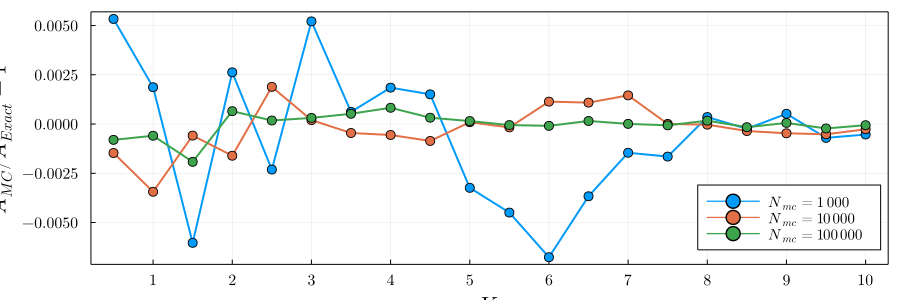

In [54]:
plot1 = plot(0.5:0.5:10,
               [relative_Nmc1K,relative_Nmc10K,relative_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               #label = ["1K" "10K" "100K"],
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.25),
               size = (900, 300),
               ylabel = L"A_{MC}/A_{Exact} -1",
               xlabel = "K",
            #    yerror= [error_relative_Nmc1K,error_relative_Nmc10K],
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

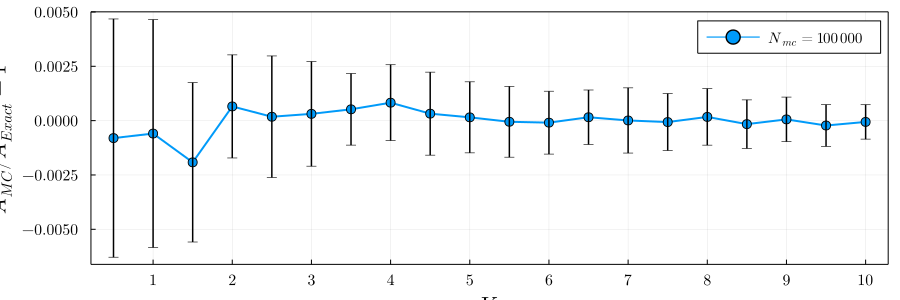

In [55]:
plot2 = plot(0.5:0.5:10,
               relative_Nmc100K,
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  L"$N_{mc}=100\,000$",
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylabel = L"A_{MC}/A_{Exact} -1",
               xlabel = "K",
               yerror= error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

In [56]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K[10:end], c0)
fit.param

4-element Vector{Float64}:
  8.512197006087616
 14.851996957714121
 27.304188695111065
  4.862355436644231e6

In [57]:

margin_error(fit, 0.05)

4-element Vector{Float64}:
  0.5861875359165891
 29.96373894072971
 62.5493952938329
  4.820338199257052e6

In [58]:
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


function get_data_mu01(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/vertex_renormalization/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.1/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_data_mu02(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.2/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu0 = error_Nmc100K_mu0./amplitude_Nmc100K_mu0;

layers_trials_mu01 = DataFrame()
for trial in 1:20
    layers_trials_mu01[!,"$(trial)"]=[get_data_mu01(100000, trial).amp[id] - get_data_mu01(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu01 =  [mean(row) for row in eachrow(layers_trials_mu01)];
layers_variance_mu01 =  [var(row) for row in eachrow(layers_trials_mu01)];
amplitude_Nmc100K_mu01 = [sum(layers_average_mu01[1:id]) for id in 1:20];
error_Nmc100K_mu01 = sqrt.([sum(layers_variance_mu01[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu01 = error_Nmc100K_mu01./amplitude_Nmc100K_mu01;

layers_trials_mu02 = DataFrame()
for trial in 1:20
    layers_trials_mu02[!,"$(trial)"]=[get_data_mu02(100000, trial).amp[id] - get_data_mu02(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu02 =  [mean(row) for row in eachrow(layers_trials_mu02)];
layers_variance_mu02 =  [var(row) for row in eachrow(layers_trials_mu02)];
amplitude_Nmc100K_mu02 = [sum(layers_average_mu02[1:id]) for id in 1:20];
error_Nmc100K_mu02 = sqrt.([sum(layers_variance_mu02[1:id]) for id in 1:20]);


relative_error_Nmc100K_mu02 = error_Nmc100K_mu02./amplitude_Nmc100K_mu02;

In [60]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu16[10:end], c0)
fit.param

4-element Vector{Float64}:
  4.075524030397469
  1.2405774270943442
  6.135875270842084
 12.879432195520664

In [61]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.060815209055860894
 0.2852429074001332
 0.2637382465724865
 7.8004000541926155

In [62]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

4-element Vector{Float64}:
  2.9833040220857163
  1.9292665756456284
  3.688154638565825
 -1.0559208462460272

In [63]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.028313011196825427
 0.1929278610025475
 0.45965886238013903
 2.6355170525472293

In [64]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mum16[10:end], c0)
fit.param

4-element Vector{Float64}:
  1.9572414712465331
  2.7025183418844922
  0.9057560961802535
 -0.7958005491337075

In [65]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.020040621630656424
 0.19162850111629282
 0.7756136673150085
 1.3326239847083996